<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Forecasting_a_time_series_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecasting a Time Series

In a previous notebook we [introduced the Recurrent Neural Networks (RNNs)](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_RNNs.ipynb). In this notebook we will use this type of networks to forecast a time series.

Suppose we are studying the number of active users per hour on our website, or our company’s financial health, measured quarterly using multiple metrics. In both cases, the data will be a sequence of one or more values per time step. This is called a *time series*. In the first example, there is a single value per time step, so it is a *univariate time series*, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a *multivariate time series*. A typical task is to predict future values, which is called *forecasting*. 

For example, we are using a time series generated by the `generate_time_series()` function, shown here:

In [1]:
import tensorflow as tf
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

This function creates as many time series as requested (via the `batch_size` argument), each of length `n_steps`, and there is just one value per time step in each series (i.e., all series are univariate). The function returns a NumPy array of shape `[batch size, time steps, 1]`, where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

- Observation: When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape `[batch size, time steps, dimensionality]`, where dimensionality is 1 for univariate time series and more for multivariate time series.

Now let’s create a training set, a validation set, and a test set using this function:



In [2]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
print(f'Shape of dataset: {series.shape}')
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {y_valid.shape}')
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of dataset: (10000, 51, 1)
Shape of X_train: (7000, 50, 1)
Shape of y_train: (7000, 1)
Shape of X_valid: (2000, 50, 1)
Shape of y_valid: (2000, 1)
Shape of X_test: (1000, 50, 1)
Shape of y_test: (1000, 1)


`X_train` contains 7,000 time series (i.e., its shape is `[7000, 50, 1]`), while `X_valid` contains 2,000 (from the 7,000th time series to the 8,999th) and `X_test` contains 1,000 (from the 9,000th to the 9,999th). Since we want to forecast a single value for each series, the targets are column vectors (e.g., `y_train` has a shape of `[7000, 1]`).

For example, the next code plot 3 univariate time series, each of them 50 time steps long, and the goal here is to forecast the value at the next time step (represented by the X) for each of them.

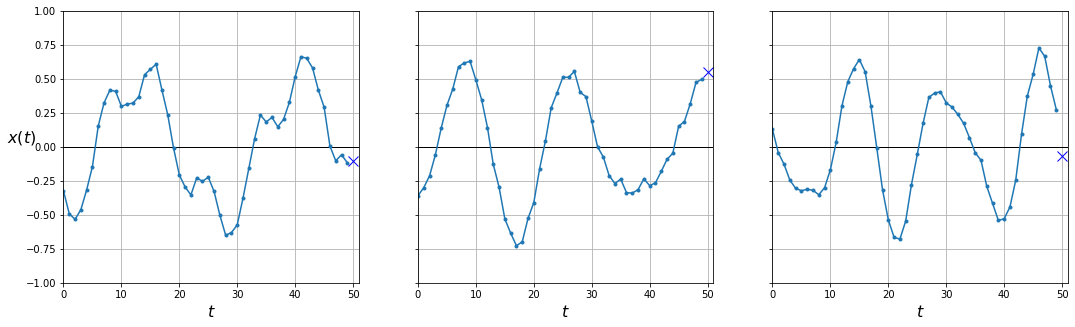

In [3]:
import matplotlib.pyplot as plt
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Baseline models

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. For example, the simplest approach is to predict the last value in each series (*naive forecasting*). In this case, it gives us a mean squared error of about 0.020:

In [4]:
import keras
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020809388

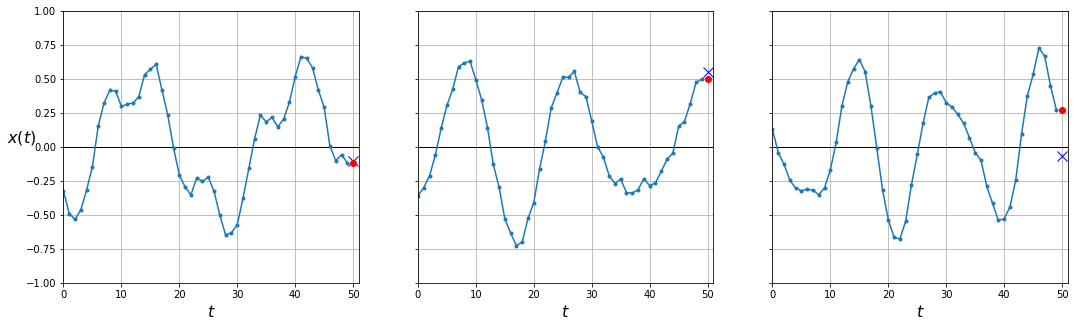

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for i in range(3):
    plt.sca(axes[i])
    plot = plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0],
                y_label=("$x(t)$" if i==0 else None))
                       
plt.show()

The red point is the value predicted by the model. The truth value is represented by the blue X.

Another simple aproach is to predict the next point to be the average of the last 50 observations. Another baseline approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a `Flatten` layer. Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

If we compile this model using the MSE loss and the default Adam optimizer, then fit it on the training set for 20 epochs and evaluate it on the validation set, we get an MSE of about 0.004. That’s much better than the naive approach!

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1026 - val_loss: 0.0547
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0403 - val_loss: 0.0267
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0154
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0139 - val_loss: 0.0111
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0092
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0060

In [8]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 717us/step - loss: 0.0040


0.003989599645137787

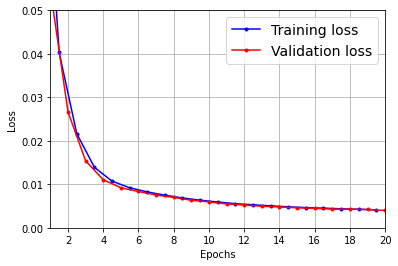

In [9]:
import matplotlib as mpl
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

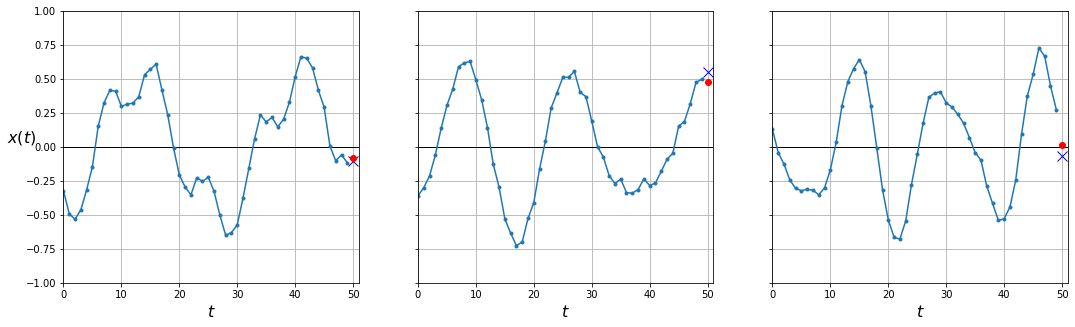

In [10]:
y_pred = model.predict(X_valid)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for i in range(3):
    plt.sca(axes[i])
    plot = plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0],
                y_label=("$x(t)$" if i==0 else None))
                       
plt.show()

### Simple RNN

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

That’s the simplest RNN we can build. It just contains a single layer, with a single neuron. We do not need to specify the length of the input sequences (unlike in the previous model), since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to `None`). By default, the `SimpleRNN` layer uses the hyperbolic tangent activation function. The initial state $h_{(init)}$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_{(0)}$. The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, $y_{(0)}$. In a simple RNN, this output is also the new state $h_{(0)}$. This new state is passed to the same recurrent neuron along with the next input value, $x_{(1)}$, and the process is repeated until the last time step. Then the layer just outputs the last value, $y_{(49)}$. All of this is performed simultaneously for every time series.

- Observation: by default, recurrent layers in Keras only return the final output. To make them return one output per time step, we must set `return_sequences=True`.

If we compile, fit, and evaluate this model (just like earlier, we train for 20 epochs using Adam), we find that its MSE reaches only 0.010, so it is better than the naive approach but it does not beat a simple linear model. Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that’s a total of 51 parameters). In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that’s just the number of recurrent neurons in the layer), plus a bias term. In this simple RNN, that’s a total of just three parameters.

In [12]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0976 - val_loss: 0.0473
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0371 - val_loss: 0.0291
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0252 - val_loss: 0.0217
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0196 - val_loss: 0.0178
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0164 - val_loss: 0.0152
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0144 - val_loss: 0.0136
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 9/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 10/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0113 - val_loss: 0.0115

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0114


0.011381915770471096

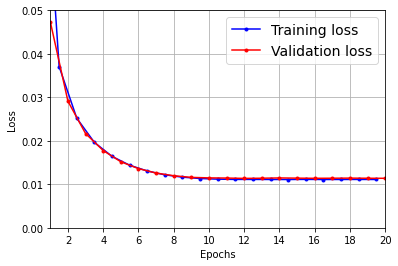

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

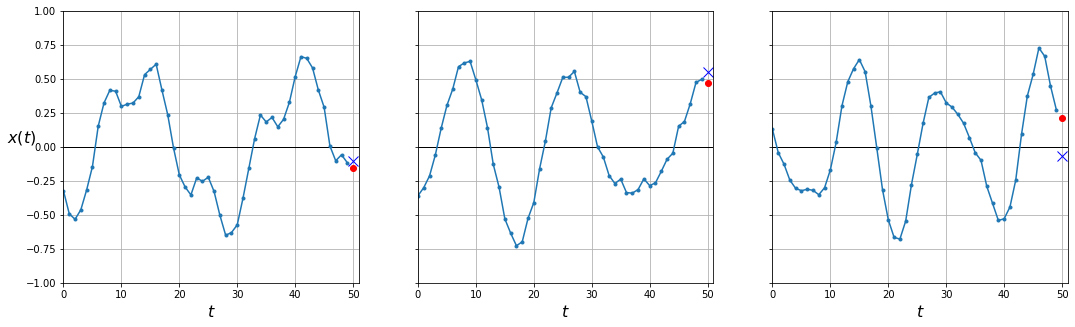

In [15]:
y_pred = model.predict(X_valid)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for i in range(3):
    plt.sca(axes[i])
    plot = plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0],
                y_label=("$x(t)$" if i==0 else None))
                       
plt.show()

### Trend and seasonality 

There are many other models to forecast time series, such as *weighted moving average* models or *autoregressive integrated moving average* (ARIMA) models. Some of them require we to first remove the trend and seasonality. For example, if we are studying the number of active users on our website, and it is growing by 10% every month, we would have to remove this trend from the time series. Once the model is trained and starts making predictions, we would have to add the trend back to get the final predictions. Similarly, if we are trying to predict the amount of sunscreen lotion sold every month, we will probably observe strong seasonality: since it sells well every summer, a similar pattern will be repeated every year. We would have to remove this seasonality from the time series, for example by computing the difference between the value at each time step and the value one year earlier (this technique is called *differencing*). Again, after the model is trained and makes predictions, we would have to add the seasonal pattern back to get the final predictions.

When using RNNs, it is generally not necessary to do all this, but it may improve performance in some cases, since the model will not have to learn the trend or the seasonality.

### Deep RNNs

It is quite common to stack multiple layers of cells, as shown in Figure 15-7. This gives us a *deep* RNN.

![texto alternativo](https://i.ibb.co/fr4Zfss/deep-RNN.png)

Implementing a deep RNN with `tf.keras` is quite simple: just stack recurrent layers. In this example, we use three `SimpleRNN` layers (but we could add any other type of recurrent layer, such as an LSTM layer or a GRU layer, which we will discuss in next notebook):

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

Note that using a `SimpleRNN` layer in the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step. However, having a single unit means that the hidden state is just a single number. That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’s hidden state very much. Moreover, since a `SimpleRNN` layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1. But what if we want to use another activation function? For both these reasons, it might be preferable to replace the output layer with a `Dense` layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. If we make this change, also make sure to remove `return_sequences=True` from the second (now last) recurrent layer.


In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

**Note**: Make sure to set return_sequences=True for all recurrent layers (except the last one, if we only care about the last output). If we don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that we are not feeding it sequences in the expected 3D format.

If we compile, fit, and evaluate this model, we find that it reaches an MSE of 0.003. We finally managed to beat the linear model!

In [18]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0229 - val_loss: 0.0053
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0029 - val_lo

In [19]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0028


0.0028207036666572094

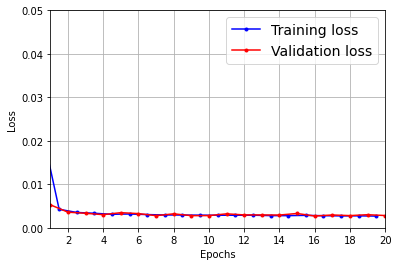

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

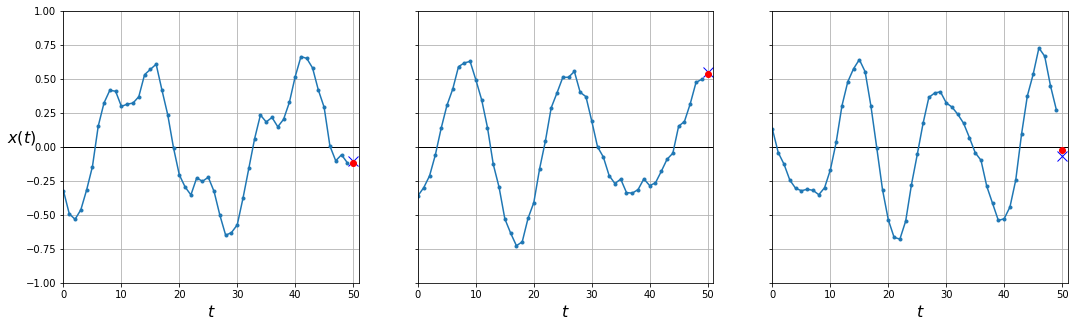

In [21]:
y_pred = model.predict(X_valid)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for i in range(3):
    plt.sca(axes[i])
    plot = plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0],
                y_label=("$x(t)$" if i==0 else None))
                       
plt.show()

### Forecasting Several Time Steps Ahead

So far we have only predicted the value at the next time step.  But what if we want to predict the next 10 values?

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on. But the prediction for the next step will usually be more accurate than the predictions for later time steps, since the errors might accumulate.



In [22]:

np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
print(Y_pred.shape)

(1, 10, 1)


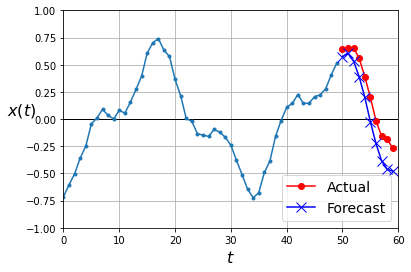

In [23]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

If we evaluate this approach on the validation set, we get an MSE of about 0.04. 

In [25]:
np.random.seed(42)
# We first need to regenerate the sequences with 9 more time steps.

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
print(f'Shape of dataset: {series.shape}')
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of Y_valid: {Y_valid.shape}')
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of Y_test: {Y_test.shape}')

Shape of dataset: (10000, 60, 1)
Shape of X_train: (7000, 50, 1)
Shape of Y_train: (7000, 10)
Shape of X_valid: (2000, 50, 1)
Shape of Y_valid: (2000, 10)
Shape of X_test: (1000, 50, 1)
Shape of Y_test: (1000, 10)


In [26]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
print(Y_pred.shape)
print(np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred)))

(2000, 10)
0.025776614


This is much higher than the previous models, but it’s also a much harder task, so the comparison doesn’t mean much. It’s much more meaningful to compare this performance with naive predictions (just forecasting that the time series will remain constant for 10 time steps) or with a simple linear model. 

In [27]:
Y_naive_pred = Y_valid[:, -1:]
print(np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred)))

0.22278848


The naive approach is terrible (it gives an MSE of about 0.223)

In [28]:
# Linear model
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0227 - val_loss: 0.0222

The linear model gives an MSE of about 0.0188: it’s much better than using our RNN to forecast the future one step at a time, and also much faster to train and run. Still, if we only want to forecast a few time steps ahead, on more complex tasks, this approach may work well.

The second option is to train an RNN to predict all 10 next values at once. We can still use a sequence-to-vector model, but it will output 10 values instead of 1. Note that we have already changed the targets to be vectors containing the next 10 values:

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10) # we just need the output layer to have 10 units instead of 1
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0110 - val_lo

After training this model, we can predict the next 10 values at once very easily:

In [30]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]


This model works nicely: the MSE for the next 10 time steps is about 0.008.

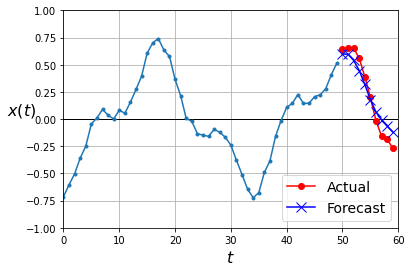

In [31]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

 But we can still do better: instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they won’t have to flow only through time; they will also flow from the output of each time step. This will both stabilize and speed up training.

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. So each target must be a sequence of the same length as the input sequence, containing a 10-dimensional vector at each step. Let’s prepare these target sequences:

In [32]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
print(f'Shape of dataset: {series.shape}')
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    #Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
Y_valid = Y[7000:9000]
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of Y_valid: {Y_valid.shape}')
Y_test = Y[9000:]
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of Y_test: {Y_test.shape}')

Shape of dataset: (10000, 60, 1)
Shape of X_train: (7000, 50, 1)
Shape of Y_train: (7000, 50, 10)
Shape of X_valid: (2000, 50, 1)
Shape of Y_valid: (2000, 50, 10)
Shape of X_test: (1000, 50, 1)
Shape of Y_test: (1000, 50, 10)


**Note**: It may be surprising that the targets will contain values that appear in the inputs (there is a lot of overlap between `X_train` and `Y_train`). Isn’t that cheating? Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be a *causal* model.

To turn the model into a *sequence-to-sequence* model, we must set `return_sequences=True` in all recurrent layers (even the last one), and we must apply the output `Dense` layer at every time step. Keras offers a `TimeDistributed` layer for this purpose: it wraps any layer (e.g., a `Dense` layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance (i.e., it reshapes the inputs from [*batch size, time steps, input dimensions*] to [*batch size × time steps, input dimensions*]; in this example, the number of input dimensions is 20 because the previous `SimpleRNN` layer has 20 units), then it runs the `Dense` layer, and finally, it reshapes the outputs back to sequences (i.e., it reshapes the outputs from [*batch size × time steps, output dimensions*] to [*batch size, time steps, output dimensions*]; in this example, the number of output dimensions is 10, since the `Dense` layer has 10 units). Here is the updated model:

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

The `Dense` layer actually supports sequences as inputs (and even higher-dimensional inputs): it handles them just like `TimeDistributed`(`Dense`(…)), meaning it is applied to the last input dimension only (independently across all time steps). Thus, we could replace the last layer with just `Dense(10)`. For the sake of clarity, however, we will keep using `TimeDistributed(Dense(10))` because it makes it clear that the `Dense` layer is applied independently at each time step and that the model will output a sequence, not just a single vector.

All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. So although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to only compute the MSE over the output at the last time step:

In [34]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))



Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0363 - val_last_time_step_mse: 0.0260
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0325 - last_time_step_mse: 0.0214 - val_loss: 0.0368 - val_last_time_step_mse: 0.0279
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0298 - last_time_step_mse: 0.0188 - val_loss: 0.0273 - val_last_time_step_mse: 0.0155
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0266 - val_last_time_step_mse: 0.0163
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0250 - last_time_step_mse: 0.0123 - val_loss: 0.0248 - val_last_time_step_mse: 0.0122
Epoch 7/20
219/219 [==

In [35]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

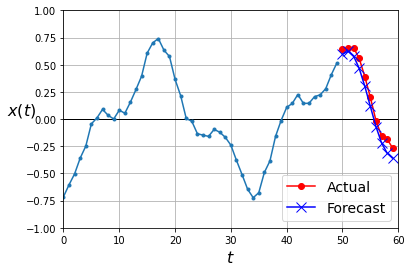

In [36]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Simple RNNs can be quite good at forecasting time series or handling other kinds of sequences, but they do not perform as well on long time series or sequences. We will discuss why and see what we can do about it in the next notebook.

# References

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- [Handson-ml2 Github](https://github.com/ageron/handson-ml2)


- [Time series forecasting TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series)


- [Forecasting: Principles and Practice](https://otexts.com/fpp2/index.html)

